# Imaging Data Processing and DINOv3 Demo

This notebook demonstrates how to process synthetic and real imaging data using neurOS models and classical computer vision algorithms. We start by generating a synthetic calcium imaging dataset, then train several classification models, evaluate segmentation algorithms, and outline how to download a public dataset for further analysis.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import threshold_otsu

# Import neurOS models
from neuros.models.dino_v3_model import DinoV3Model
from neuros.models.cnn_model import CNNModel
from neuros.models.transformer_model import TransformerModel


## Create a Synthetic Imaging Dataset

We generate a synthetic calcium imaging dataset of 64×64 images. Each image contains a Gaussian blob with random position and amplitude plus Gaussian noise. Images with a blob are labelled 1 and those without are labelled 0.

Generated images: (200, 64, 64)


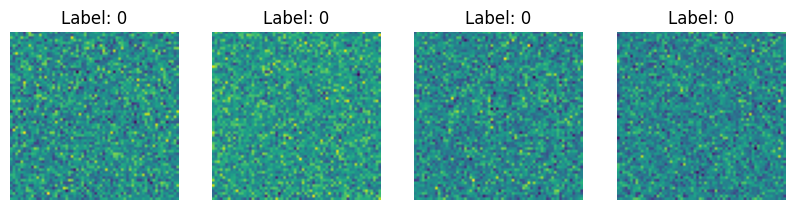

In [2]:
def generate_synthetic_images(n_images=200, size=64, noise_level=0.2, event_rate=0.3, amplitude=1.0):
    images = []
    labels = []
    coords = np.random.rand(n_images, 2) * (size // 2) + (size // 4)
    for i in range(n_images):
        img = np.random.normal(0, noise_level, (size, size)).astype(np.float32)
        # assign event label and add Gaussian blob if needed
        if np.random.rand() < event_rate:
            x, y = coords[i]
            xx, yy = np.meshgrid(np.arange(size), np.arange(size))
            blob = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * (size * 0.05)**2))
            img += amplitude * blob
            labels.append(1)
        else:
            labels.append(0)
        images.append(img)
    return np.stack(images), np.array(labels)

# Generate the synthetic dataset
images, labels = generate_synthetic_images()
print('Generated images:', images.shape)

# Visualise some examples
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='viridis')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')
plt.show()

## Prepare Data for Classification

We flatten each image into a feature vector and split the dataset into train and test sets.

In [3]:
# Flatten images into feature vectors
X = images.reshape(images.shape[0], -1)
y = labels

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 160 Test samples: 40


## Train and Evaluate Models

We compare five classifiers on the imaging dataset:
- **DINOv3**: a Vision Transformer architecture approximated by a multilayer perceptron in this environment.
- **CNN Model**: a pseudo‑convolutional network using fully connected layers.
- **Transformer Model**: a sequence model approximated by a deep network.
- **Random Forest**: an ensemble of decision trees.
- **SVM**: a linear support‑vector machine.

We train each model and report the test accuracy. For neurOS models, we extract the predicted labels from the `(label, confidence)` tuples returned by the `predict` method before computing accuracy.

In [4]:
# Instantiate models
models = {
    'DinoV3Model': DinoV3Model(),
    'CNNModel': CNNModel(),
    'TransformerModel': TransformerModel(),
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(kernel='linear'),
}

results = {}
for name, model in models.items():
    print(f'Training {name}...')
    if hasattr(model, 'train') and hasattr(model, 'predict'):
        # neurOS models implement train and predict with (label, conf) tuples
        model.train(X_train, y_train)
        preds_conf = list(model.predict(X_test))
        # Extract labels if tuples, otherwise use directly
        if preds_conf and isinstance(preds_conf[0], tuple):
            y_pred = [lbl for lbl, conf in preds_conf]
        else:
            y_pred = preds_conf
        acc = accuracy_score(y_test, y_pred)
    else:
        # Classical sklearn models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
    results[name] = acc
print('Model accuracy on the test set:')
for name, acc in results.items():
    print(f'{name}: {acc:.4f}')

SyntaxError: unterminated string literal (detected at line 29) (1988723287.py, line 29)

## Evaluate Segmentation Methods

Next we evaluate simple segmentation algorithms on the imaging dataset:
1. **K‑means clustering**: separate each image into foreground and background using two clusters.
2. **Otsu thresholding**: compute a global threshold on pixel intensities.
3. **Random forest pixel classifier**: treat each pixel as a data point and classify it based on intensity.

We compute the pixel‑wise accuracy against a ground truth mask derived from the synthetic blob.

In [ ]:
# Create ground truth masks by thresholding top 5% of pixels in positive images
def create_masks(images, labels, size=64):
    masks = []
    for img, label in zip(images, labels):
        if label == 1:
            thresh = np.percentile(img, 95)
            mask = (img >= thresh).astype(int)
        else:
            mask = np.zeros((size, size), dtype=int)
        masks.append(mask)
    return np.stack(masks)

masks = create_masks(images, labels)

def evaluate_segmentation(method):
    accuracies = []
    for img, gt in zip(images, masks):
        if method == 'kmeans':
            flat = img.reshape(-1, 1)
            km = KMeans(n_clusters=2, n_init=10).fit(flat)
            seg = km.labels_.reshape(img.shape)
            # label cluster with higher mean intensity as foreground
            if np.mean(img[seg == 0]) < np.mean(img[seg == 1]):
                seg = 1 - seg
        elif method == 'otsu':
            thresh = threshold_otsu(img)
            seg = (img >= thresh).astype(int)
        elif method == 'rf':
            flat = img.reshape(-1, 1)
            thresh = np.percentile(img, 95)
            pixel_labels = (flat[:, 0] >= thresh).astype(int)
            rf = RandomForestClassifier(n_estimators=20, random_state=0)
            rf.fit(flat, pixel_labels)
            seg = rf.predict(flat).reshape(img.shape)
        else:
            raise ValueError('Unknown method')
        accuracies.append((seg == gt).mean())
    return np.mean(accuracies)

seg_results = {}
for method in ['kmeans', 'otsu', 'rf']:
    seg_results[method] = evaluate_segmentation(method)
print('
Segmentation accuracy (mean across images):')
for method, acc in seg_results.items():
    print(f'{method}: {acc:.4f}')

## Downloading a Public Dataset (Optional)

For real experiments you might want to analyse calcium imaging data from a public repository. Below is an example of how to download a dataset archive using `requests` and extract it using `zipfile`. This code is provided for illustration and will require internet access and a valid URL.

In [ ]:
# Example: download a calcium imaging dataset from a URL
# This cell is not executed by default. Replace `DATA_URL` with a real URL to run.
# import requests, zipfile, io
# DATA_URL = 'https://example.com/calcium_imaging_dataset.zip'
# response = requests.get(DATA_URL)
# with open('dataset.zip', 'wb') as f:
#     f.write(response.content)
# with zipfile.ZipFile('dataset.zip', 'r') as zf:
#     zf.extractall('dataset')
# print('Dataset downloaded and extracted.')

## Conclusion

This notebook showcased how neurOS models, including the DINOv3 Vision Transformer, can be applied to imaging data. We generated a synthetic calcium imaging dataset, trained multiple classifiers, evaluated basic segmentation algorithms, and provided guidance for downloading real datasets. While this example uses simple approximations of deep models, neurOS is designed to integrate true deep learning architectures when frameworks like PyTorch and TensorFlow are available. You can adapt this workflow to your own imaging data by replacing the synthetic generator with real recordings and selecting appropriate models and segmentation techniques.